## Data loading

In [2]:
import h5py
import numpy as np
from pathlib import Path

In [25]:
colab = True

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !unzip '/content/drive/My Drive/PatternRecognition/data.zip' -d '/content/data'
    data_dir = Path("./data/") / "Final Project data"
else:
  data_dir = Path("./data/")

assert data_dir.is_dir()
intra_dir = data_dir / "Intra"
cross_dir = data_dir / "Cross"
cross_train_glob = list((cross_dir / "train").glob("*.h5"))
cross_test1_glob = list((cross_dir / "test1").glob("*.h5"))
cross_test2_glob = list((cross_dir / "test2").glob("*.h5"))
print(len(cross_train_glob), len(cross_test1_glob), len(cross_test2_glob))

32

In [26]:
def load_labels(path: Path) -> np.ndarray:
    *task, subject_identifier, chunk = path.stem.split("_")
    if "rest" in task:
        y = 0
    elif 'math' in task:
        y = 1
    elif 'working' in task:
        y = 2
    elif 'motor' in task:
        y = 3
    else:
        assert False, 'unknown task'
    return np.array([y, int(subject_identifier), int(chunk)])

In [27]:
def load_h5(path: Path) -> np.ndarray:
    with h5py.File(path) as f:
        keys = f.keys()
        assert len(keys) == 1, f"Only one key per file, right? {cross_train_glob[0]}"
        matrix = f.get(next(iter(keys)))[()]
    return matrix


cross_train_X = np.stack(list(map(load_h5, cross_train_glob)))
cross_train_labels = np.stack(list(map(load_labels, cross_train_glob)))[:, 0]

((32, 248, 35624), (32,))

In [28]:
#Load first test dataset
cross_test1_X = np.stack(list(map(load_h5, cross_test1_glob)))
cross_test1_labels = np.stack(list(map(load_labels, cross_test1_glob)))

#Load second test dataset
cross_test2_X = np.stack(list(map(load_h5, cross_test2_glob)))
cross_test2_labels = np.stack(list(map(load_labels, cross_test2_glob)))

#Combine two datasets
cross_test_X = np.concatenate([cross_test1_X, cross_test2_X], axis=0)
cross_test_labels = np.concatenate([cross_test1_labels, cross_test2_labels], axis=0)

#Create a common shuffle
indices = np.arange(len(cross_test_X))
np.random.shuffle(indices)

#Shuffle
cross_test_X = cross_test_X[indices]
cross_test_labels = cross_test_labels[indices][:, 0] #only keep the first dim 
print(cross_test_X.shape, cross_test_labels.shape)

((8, 248, 35624), (8, 3))

## Data preprocessing

In [10]:
import numpy as np
import torch

def downsample(data, old_freq, new_freq):
    # Calculate the downsampling factor
    downsample_factor = int(np.round(old_freq / new_freq))
    # Ensure that timesteps are divisible by the downsampling factor
    data = data[:,:,:data.shape[2]//downsample_factor*downsample_factor]
    # Reshape
    reshaped_data = data.reshape(data.shape[0], data.shape[1], -1, downsample_factor)
    # Take the mean along the last axis
    downsampled_data = reshaped_data.mean(axis=-1)
    return downsampled_data

def z_score_normalize(data):
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    # Calculate mean and std along the timesteps
    mean = torch.mean(data_tensor, dim=2, keepdim=True)
    std = torch.std(data_tensor, dim=2, keepdim=True)
    # Perform z-score norm
    normalized_data = (data_tensor - mean) / std
    return normalized_data

cross_train_X_norm = z_score_normalize(downsample(cross_train_X, 2034, 60))
cross_test_X_norm = z_score_normalize(downsample(cross_test_X, 2034, 60))

print(cross_train_X_norm.shape, cross_test_X_norm.shape)

torch.Size([32, 248, 2226])


## VAR-CNN Architecture
implemented from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6609925/

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

#Define based on the input data shape
n_classes = 4
input_channels = 248
input_height = 1047
input_width = 1

# Define the neural network module
class VectorAutoregressiveCNN(nn.Module):
    def __init__(self, input_channels, k, l, n_classes):
        super(VectorAutoregressiveCNN, self).__init__()
        #2D Conv
        self.conv = nn.Conv2d(input_channels, k, (l, 1))
        # Max Pooling
        self.pool = nn.MaxPool2d((2, 1), stride=(2, 1))
        # Calculate output shape after conv and pool
        conv_output_height = (input_height - l + 1) // 2
        conv_output_width = 1
        ninputs = k * conv_output_height * conv_output_width
        #Fully Connected Layer
        self.fc = nn.Linear(ninputs, n_classes)
        self.l1_penalty = 3e-4

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def l1_regularization(self):
        l1_norm = sum(p.abs().sum() for p in self.parameters())
        return self.l1_penalty * l1_norm

# Instantiate the model
device = torch.device("cuda")
#model = VectorAutoregressiveCNN(input_channels, k, l, n_classes)
#model.to(device)

# Define the optimizer and loss function
#optimizer = Adam(model.parameters(), lr=0.00001)
loss_function = nn.CrossEntropyLoss()

## Training

In [37]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from sklearn.model_selection import ParameterGrid

batch_size = 8
num_epochs = 30

dataset = TensorDataset(torch.tensor(cross_train_X_norm.unsqueeze(-1)), torch.tensor(cross_train_labels).long())
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.tensor(cross_test_X_norm.unsqueeze(-1)), torch.tensor(cross_test_labels).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Variables for early stopping
early_stopping_patience = 100
best_loss = np.inf
patience_counter = 0

# Reset the early stopping patience
patience_counter = 0
best_loss = np.inf

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Define the parameter grid for GridSearch
param_grid = {
    'lr': [0.00001, 0.0001, 0.001],
    'weight_decay': [1e-4, 1e-3, 1e-2],
    'batch_size': [8, 16, 32],
    'num_epochs': [10, 20, 30],
    'k':[16, 32, 64],
    'l':[3, 5, 7]
}
grid = ParameterGrid(param_grid)
best_params = None
best_test_loss = np.inf


for params in grid:
  batch_size = params['batch_size']
  num_epochs = params['num_epochs']
  model = VectorAutoregressiveCNN(input_channels, params['k'], params['l'], n_classes)
  optimizer = Adam(model.parameters(), lr=params['lr'])
  model.to(device)

  for epoch in range(num_epochs):
    #print(f"Epoch {epoch + 1}")

    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target) + model.l1_regularization()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Curr Accuracy
        _, predicted = torch.max(output.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item() 

    # Average loss and accuracy over the epoch
    train_loss /= len(dataset)
    train_accuracy = correct_predictions / total_predictions 

    #print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")          

    # Validation 
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()  # Sum up batch loss

            # Curr Accuracy
            _, predicted = torch.max(output.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()


    test_loss /= len(test_loader.dataset)  # Get the average loss
    test_accuracy = correct_predictions / total_predictions
    
    # print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
    # train_losses.append(train_loss)
    # train_accuracies.append(train_accuracy)
    # test_losses.append(test_loss)
    # test_accuracies.append(test_accuracy)

    # Early stopping logic
    if test_loss < best_loss:
        # print(f"For params: {params}")
        # print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}") 
        # print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
        patience_counter = 0
        best_params = params
        #save the model 
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_loss': best_loss,
            'best_accuracy': test_accuracy}
        torch.save(checkpoint, f'cnn_checkpoint.pt')
        #print(f"Checkpoint saved at epoch {epoch}")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            #print("Early stopping triggered.")
            break

# Print the best parameters after the loop
print(f"Best Hyperparameters: {best_params}, Training loss: {train_loss}, Testing loss: {test_loss}, Training accuracy: {train_accuracy}, Testing accuracy: {test_accuracy}")

C:\Users\marie\AppData\Local\Temp\ipykernel_23284\3717209327.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(intra_train_X_norm.unsqueeze(-1)), torch.tensor(intra_train_labels_stripped).long())


Fold 1
Epoch 1
Training loss: 0.017276661396026613, Training accuracy: 1.0
Validation loss: 0.0001438441187409418, Validation accuracy: 1.0
Checkpoint saved for fold 0 at epoch 0
Epoch 2
Training loss: 0.017176350951194762, Training accuracy: 1.0
Validation loss: 0.00014764012303203344, Validation accuracy: 1.0
Epoch 3
Training loss: 0.01715212106704712, Training accuracy: 1.0
Validation loss: 0.00015292266782905375, Validation accuracy: 1.0
Epoch 4
Training loss: 0.01704555869102478, Training accuracy: 1.0
Validation loss: 0.00015892598977578537, Validation accuracy: 1.0
Epoch 5
Training loss: 0.017002911269664765, Training accuracy: 1.0
Validation loss: 0.00016551463132990257, Validation accuracy: 1.0
Fold 2
Epoch 1
Training loss: 0.01697812885046005, Training accuracy: 1.0
Validation loss: 8.517720769824726e-05, Validation accuracy: 1.0
Checkpoint saved for fold 1 at epoch 0
Epoch 2
Training loss: 0.01687861979007721, Training accuracy: 1.0
Validation loss: 8.693024782197816e-05, Va

## Plot performance

training acc = val acc that's why there's only one line in plot 2

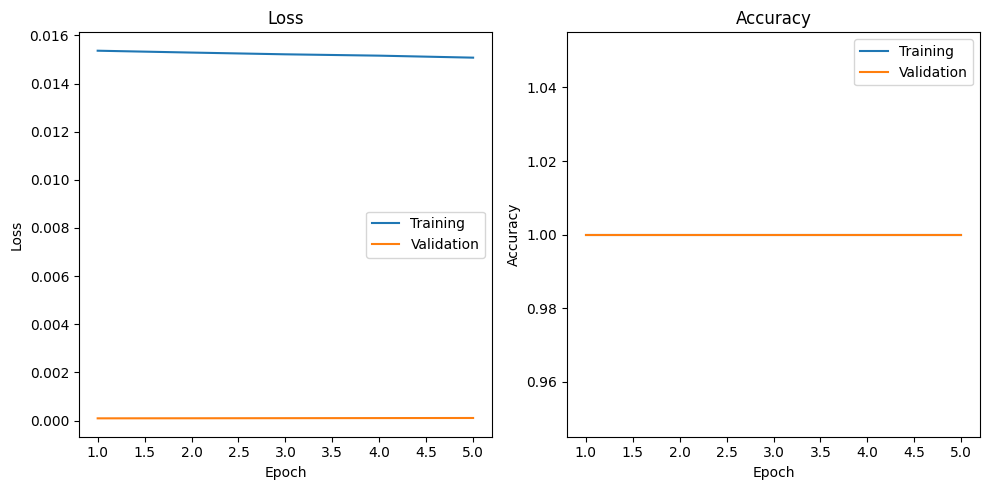

In [44]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training')
plt.plot(epochs, val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training')
plt.plot(epochs, val_accuracies, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### Further Training (optional)

Load the model checkpoint

In [ ]:
model = VectorAutoregressiveCNN(input_channels, k, l, n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Load the model and optimizer state_dict
checkpoint = torch.load('cnn_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()  # For inference
model.train()  # For further training